# Ligand-protein MD

This tutorial showcases how to use ProLIF to generate an interaction fingerprint for a ligand-protein complex from an MD simulation.

ProLIF uses MDAnalysis to process MD simulations, as it supports many [file formats](https://userguide.mdanalysis.org/stable/formats/index.html) and is inter-operable with RDKit (which ProLIF uses under the hood to implement the different types of interactions). To learn more on how to use MDAnalysis, you can find their user guide [here](https://userguide.mdanalysis.org/stable/index.html).

We will use 3 objects from the MDAnalysis library:

- The `Universe` which bundles the atoms and bonds of your system with the coordinates in your trajectory.
- The `AtomGroup` which is a collection of atoms that you can define by applying a [selection](https://userguide.mdanalysis.org/stable/selections.html) on the `Universe`.
- The trajectory (or most often a subset of it) to know which frames to process.

:::{important}
For convenience, the topology and trajectory files for this tutorial are included with the ProLIF installation, and you can access the path to both files through `prolif.datafiles.TOP` and `prolif.datafiles.TRAJ` respectively. **Remember to switch these with the actual paths to your inputs outside of this tutorial.**
:::

:::{tip}
At the top of the page you can find links to either download this notebook or run it in
Google Colab. You can install the dependencies for the tutorials with the command:

```shell
pip install prolif[tutorials]
```
:::

In [1]:
####################################################################################
import joblib
import warnings
from sklearn.exceptions import DataConversionWarning

# 忽略特定类型的警告
warnings.filterwarnings("ignore", category=DataConversionWarning)
###########修改字体
from matplotlib import font_manager
from matplotlib import pyplot as plt  # 将 matplotlib 导入放在前面
# 查找系统中所有可用的Times New Roman字体的路径
times_new_roman = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
# 从列表中找到一个指定的字体名称
t_nr_path = [f for f in times_new_roman if 'Times New Roman' in f]

if t_nr_path:
    # 如果找到了Times New Roman字体，设置为默认字体
    prop = font_manager.FontProperties(fname=t_nr_path[0])
    plt.rcParams['font.family'] = prop.get_name()
else:
    # 如果没有找到，使用另一种可用的衬线字体
    plt.rcParams['font.family'] = 'serif'

from matplotlib import font_manager, pyplot as plt

# 查找系统中所有可用的Times New Roman字体的路径
times_new_roman = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
# 从列表中找到一个指定的字体名称，并确保字体能支持加粗
t_nr_path = [f for f in times_new_roman if 'Times New Roman' in f and 'Bold' in f]

if t_nr_path:
    # 如果找到了Times New Roman Bold字体，设置为默认字体
    prop = font_manager.FontProperties(fname=t_nr_path[0])
    plt.rcParams['font.family'] = prop.get_name()
    plt.rcParams['font.weight'] = 'bold'  # 设置字体为加粗
else:
    # 如果没有找到加粗的Times New Roman，尝试设置为普通的Times New Roman并加粗
    t_nr_path = [f for f in times_new_roman if 'Times New Roman' in f]
    if t_nr_path:
        prop = font_manager.FontProperties(fname=t_nr_path[0])
        plt.rcParams['font.family'] = prop.get_name()
        plt.rcParams['font.weight'] = 'bold'
    else:
        # 如果没有找到Times New Roman，使用默认的衬线字体并设置为加粗
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['font.weight'] = 'bold'
#################################################################################

## Preparation

Let's start by importing MDAnalysis and ProLIF to read our tutorial files, and create selections for the ligand and protein:

In [2]:
import MDAnalysis as mda

# 加载拓扑和轨迹文件
u = mda.Universe('pull_complex.pdb', 'pull_complex.xtc')

# 查找所有名为 'Gen' 的配体
ligand_atoms = u.select_atoms('resname Gen')

# 修改配体名称为 'MOL'
for atom in ligand_atoms:
    atom.residue.resname = 'MOL'

# 保存修改后的轨迹
u.trajectory[0]  # 访问轨迹帧
with mda.Writer('pull_complex2.xtc', u.atoms.n_atoms) as W:
    for ts in u.trajectory:
        W.write(u)

In [3]:
import MDAnalysis as mda
import prolif as plf

# load topology and trajectory
# u = mda.Universe(plf.datafiles.TOP, plf.datafiles.TRAJ)
u = mda.Universe('pull_complex2.pdb', 'pull_complex2.xtc')

# create selections for the ligand and protein
ligand_selection = u.select_atoms("resname MOL")
protein_selection = u.select_atoms("protein")
ligand_selection, protein_selection

/home/dl01/software/anaconda3/envs/pyemma/lib/python3.8/site-packages/MDAnalysis/coordinates/XDR.py:241: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


(<AtomGroup with 30 atoms>, <AtomGroup with 13982 atoms>)

In [3]:
# import MDAnalysis as mda
# import prolif as plf

# # load topology and trajectory
# u = mda.Universe('./Gen-1ns/md_prolig.pdb', './Gen-1ns/md_prolig.xtc')

# # create selections for the ligand and protein
# ligand_selection = u.select_atoms("resname MOL")
# protein_selection = u.select_atoms("protein")
# ligand_selection, protein_selection


# protein_selection = u.select_atoms(
#     "protein and byres around 20.0 group ligand", ligand=ligand_selection
# )
# protein_selection


# # create a molecule from the MDAnalysis selection
# ligand_mol = plf.Molecule.from_mda(ligand_selection)
# # display
# plf.display_residues(ligand_mol, size=(400, 200))


# # Assuming bond information is adequately present, skip guess_bonds or use if needed
# ligand_selection.guess_bonds()
# protein_selection.guess_bonds()


# protein_mol = plf.Molecule.from_mda(protein_selection)
# plf.display_residues(protein_mol, slice(20))

# # Fingerprint analysis
# plf.Fingerprint.list_available()


# # use default interactions
# fp = plf.Fingerprint()
# # run on a slice of the trajectory frames: from begining to end with a step of 10
# fp.run(u.trajectory[::10], ligand_selection, protein_selection)


# # Optionally, save and load the fingerprint data
# fp.to_pickle("./Gen-1ns/fingerprint.pkl")
# fp = plf.Fingerprint.from_pickle("./Gen-1ns/fingerprint.pkl")

MDAnalysis should automatically recognize the file type that you're using from its extension. 

:::{note}
Click [here](https://userguide.mdanalysis.org/stable/examples/quickstart.html) to learn more about loading files with MDAnalysis,
and [here](https://userguide.mdanalysis.org/stable/selections.html) to learn more about their atom selection language.
:::

In our case the protein is of reasonable size, but if you're working with a very large system, to save some time and memory it may be wise to restrict the protein selection to a sphere around the ligand:

In [4]:
protein_selection = u.select_atoms(
    "protein and byres around 20.0 group ligand", ligand=ligand_selection
)
protein_selection

<AtomGroup with 5121 atoms>

Depending on your system, it may be of interest to also include water molecules in the protein selection. There are none in this tutorial example but something like this could be used:

In [ ]:
# protein_selection = u.select_atoms(
#     "(protein or resname WAT) and byres around 20.0 group ligand",
#     ligand=ligand_selection,
# )
# protein_selection

Next, lets make sure that our ligand was correctly read by MDAnalysis.

:::{important}
This next step is crucial if you're loading a structure from a file that doesn't
explicitely contain bond orders and formal charges, such as a PDB file or most MD
trajectory files. MDAnalysis will infer those from the atoms connectivity, which
**requires all atoms including hydrogens to be present in the input file**.
:::

Since ProLIF molecules are built on top of RDKit, we can use RDKit functions to display molecules. Let's have a quick look at our ligand:

/home/dl01/software/anaconda3/envs/pyemma/lib/python3.8/site-packages/MDAnalysis/converters/RDKit.py:451: UserWarning: No `bonds` attribute in this AtomGroup. Guessing bonds based on atoms coordinates
  warnings.warn(


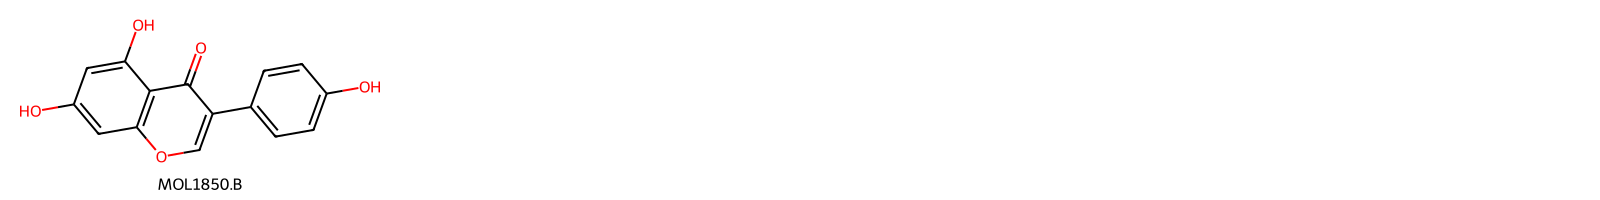

In [5]:
# create a molecule from the MDAnalysis selection
ligand_mol = plf.Molecule.from_mda(ligand_selection)
# display
plf.display_residues(ligand_mol, size=(400, 200))

In [6]:
# Assuming bond information is adequately present, skip guess_bonds or use if needed
ligand_selection.guess_bonds()
protein_selection.guess_bonds()

We can do the same for the residues in the protein (only showing the first 20 to keep the notebook short):

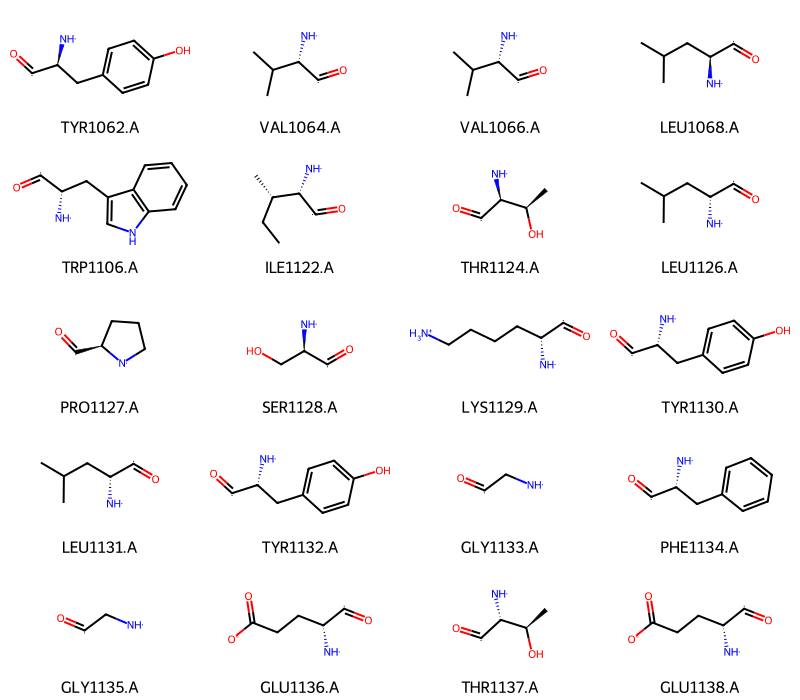

In [7]:
protein_mol = plf.Molecule.from_mda(protein_selection)
# remove the `slice(20)` part to show all residues
plf.display_residues(protein_mol, slice(20))

:::{admonition} Troubleshooting

If one of the two molecules was not processed correctly, it might be because your input file does not contain bond information. If that's the case, please add this snippet right after creating your selections:

```python
ligand_selection.guess_bonds()
protein_selection.guess_bonds()
```

In some cases, some atomic clashes may be incorrectly classified as bonds and will prevent the conversion of MDAnalysis molecules to RDKit. Since MDAnalysis uses van der Waals radii for bond detection, one can modify the default radii that are used:

```python
protein_selection.guess_bonds(vdwradii={"H": 1.05, "O": 1.48})
```
:::

## Fingerprint generation

Everything looks good, we can now generate a fingerprint. By default, ProLIF will calculate the following interactions: Hydrophobic, HBDonor, HBAcceptor, PiStacking, Anionic, Cationic, CationPi, PiCation, VdWContact.
You can list all interactions that are available with the following command:

In [8]:
plf.Fingerprint.list_available()

['Anionic',
 'CationPi',
 'Cationic',
 'EdgeToFace',
 'FaceToFace',
 'HBAcceptor',
 'HBDonor',
 'Hydrophobic',
 'MetalAcceptor',
 'MetalDonor',
 'PiCation',
 'PiStacking',
 'VdWContact',
 'XBAcceptor',
 'XBDonor']

:::{tip}
The default fingerprint will only keep track of the first group of atoms that satisfied the constraints per interaction type and residue pair.

If you want to keep track of all possible interactions to generate a count-fingerprint (e.g. when there are two atoms in the ligand that make an HBond-donor interaction with residue X), use `plf.Fingerprint(count=True)`.
This is also quite useful for visualization purposes as you can then display the atom pair that has the shortest distance which will look more accurate.
This fingerprint type is however a bit slower to compute.
:::

In [9]:
# use default interactions
fp = plf.Fingerprint()
# run on a slice of the trajectory frames: from begining to end with a step of 10
fp.run(u.trajectory[::10], ligand_selection, protein_selection)

  0%|          | 0/51 [00:00<?, ?it/s]

<prolif.fingerprint.Fingerprint: 9 interactions: ['Hydrophobic', 'HBAcceptor', 'HBDonor', 'Cationic', 'Anionic', 'CationPi', 'PiCation', 'PiStacking', 'VdWContact'] at 0x1553c2cf1640>

:::{tip}
The `run` method will automatically select residues that are close to the ligand (6.0 Å) when computing the fingerprint. You can modify the 6.0 Å cutoff by specifying `plf.Fingerprint(vicinity_cutoff=7.0)`, but this is only useful if you decide to change the distance parameters for an interaction class (see in the advanced section of the tutorials).

Alternatively, you can pass a list of residues like so:

```python
fp.run(<other parameters>, residues=["TYR38.A", "ASP129.A"])
```
:::

You can save the fingerprint object with `fp.to_pickle` and reload it later with `Fingerprint.from_pickle`:

In [11]:
fp.to_pickle("./frame500/fingerprint.pkl")
fp = plf.Fingerprint.from_pickle("./frame500/fingerprint.pkl")

## Analysis

Once the execution is done, you can access the results through `fp.ifp` which is a nested dictionary:

In [12]:
frame_number = 0
ligand_residue = "MOL1850.B"
protein_residue = "LYS1536.A"

fp.ifp[frame_number][(ligand_residue, protein_residue)]

{'Hydrophobic': ({'indices': {'ligand': (8,), 'protein': (4,)},
   'parent_indices': {'ligand': (8,), 'protein': (3268,)},
   'distance': 4.460608104083742},),
 'VdWContact': ({'indices': {'ligand': (20,), 'protein': (21,)},
   'parent_indices': {'ligand': (20,), 'protein': (3285,)},
   'distance': 2.542937355809195},)}

While this contains all the details about the different interactions that were detected, it's not the easiest thing to digest.

The best way to analyse our results is to export the interaction fingerprint to a Pandas DataFrame. You can read more about pandas in their
[user_guide](https://pandas.pydata.org/docs/user_guide/index.html).

In [13]:
df = fp.to_dataframe()
# show only the 10 first frames
df.head(10)

ligand       MOL1850.B                                               \
protein      GLU1136.A             THR1137.A              GLU1138.A   
interaction HBAcceptor VdWContact HBAcceptor VdWContact Hydrophobic   
Frame                                                                 
0                False       True      False      False        True   
10               False       True      False      False        True   
20                True       True      False       True        True   
30               False       True      False       True        True   
40               False      False      False      False        True   
50               False      False      False      False        True   
60               False      False       True       True        True   
70               False       True      False      False        True   
80               False      False      False      False        True   
90               False      False      False      False        True   

ligand                                                                ...  \
protein                  PRO1159.A              PRO1160.A             ...   
interaction VdWContact Hydrophobic VdWContact Hydrophobic VdWContact  ...   
Frame                                                                 ...   
0                False       False      False        True      False  ...   
10               False       False      False        True       True  ...   
20                True       False      False        True       True  ...   
30               False       False      False        True       True  ...   
40                True       False      False        True       True  ...   
50                True       False      False        True       True  ...   
60                True       False      False        True       True  ...   
70               False       False      False        True       True  ...   
80                True       False      False        True       True  ...   
90                True        True      False        True       True  ...   

ligand                                                                        \
protein       LYS1536.A             GLY1540.A   GLU1543.A                      
interaction Hydrophobic VdWContact VdWContact Hydrophobic HBDonor VdWContact   
Frame                                                                          
0                  True       True      False       False    True       True   
10                 True       True       True        True    True       True   
20                 True       True       True        True    True       True   
30                 True       True       True        True    True       True   
40                 True       True       True        True    True       True   
50                 True       True       True        True    True       True   
60                 True       True      False       False    True       True   
70                 True      False      False       False    True       True   
80                 True      False      False       False   False      False   
90                 True      False      False       False   False      False   

ligand                                                     
protein       PHE1544.A              PHE1560.A             
interaction Hydrophobic VdWContact Hydrophobic VdWContact  
Frame                                                      
0                  True       True       False      False  
10                 True       True       False      False  
20                 True       True       False      False  
30                 True      False       False      False  
40                 True      False       False      False  
50                 True       True       False      False  
60                 True       True       False      False  
70                 True      False       False      False  
80                 True       True       False      False  
90                False  

Here are some common pandas snippets to extract useful information from the fingerprint table.

:::{important}
Make sure to remove the `.head(5)` at the end of the commands to display the results for all the frames.
:::

In [14]:
# hide an interaction type (Hydrophobic)
df.drop("Hydrophobic", level="interaction", axis=1).head(5)

ligand       MOL1850.B                                                         \
protein      GLU1136.A             THR1137.A             GLU1138.A  PRO1159.A   
interaction HBAcceptor VdWContact HBAcceptor VdWContact VdWContact VdWContact   
Frame                                                                           
0                False       True      False      False      False      False   
10               False       True      False      False      False      False   
20                True       True      False       True       True      False   
30               False       True      False       True      False      False   
40               False      False      False      False       True      False   

ligand                                                 ...             \
protein      PRO1160.A  ARG1455.A                      ...  THR1528.A   
interaction VdWContact HBAcceptor PiCation VdWContact  ... HBAcceptor   
Frame                                                  ...              
0                False      False    False      False  ...      False   
10                True      False    False      False  ...      False   
20                True      False    False      False  ...      False   
30                True      False    False      False  ...      False   
40                True      False    False      False  ...      False   

ligand                                                                       \
protein                GLN1533.A             LYS1536.A  GLY1540.A GLU1543.A   
interaction VdWContact   HBDonor VdWContact VdWContact VdWContact   HBDonor   
Frame                                                                         
0                False     False      False       True      False      True   
10               False      True       True       True       True      True   
20               False      True       True       True       True      True   
30               False      True       True       True       True      True   
40               False      True       True       True       True      True   

ligand                                        
protein                 PHE1544.A  PHE1560.A  
interaction VdWContact VdWContact VdWContact  
Frame                                         
0                 True       True      False  
10                True       True      False  
20                True       True      False  
30                True      False      False  
40                True      False      False  

[5 rows x 29 columns]

In [15]:
# show only one protein residue (ASP129.A)
df.xs("LYS1536.A", level="protein", axis=1).head(5)

ligand        MOL1850.B           
interaction Hydrophobic VdWContact
Frame                             
0                  True       True
10                 True       True
20                 True       True
30                 True       True
40                 True       True

In [16]:
# # show only an interaction type (PiStacking)
# df.xs("PiStacking", level="interaction", axis=1).head(5)

In [17]:
# percentage of the trajectory where each interaction is present
(df.mean().sort_values(ascending=False).to_frame(name="%").T * 100)

ligand        MOL1850.B                                                \
protein       PRO1159.A   PRO1160.A             ASN1527.A   GLU1138.A   
interaction Hydrophobic Hydrophobic VdWContact VdWContact Hydrophobic   
%             39.215686   37.254902  35.294118  33.333333   31.372549   

ligand                                                                 ...  \
protein       LEU1524.A   LYS1536.A  LEU1524.A  ASP1526.A   PHE1544.A  ...   
interaction Hydrophobic Hydrophobic VdWContact VdWContact Hydrophobic  ...   
%              27.45098    27.45098  21.568627  19.607843   17.647059  ...   

ligand                                                                        \
protein      PHE1560.A ASN1527.A  GLY1525.A  THR1528.A             LEU1524.A   
interaction VdWContact   HBDonor VdWContact HBAcceptor Hydrophobic   HBDonor   
%             3.921569  3.921569   3.921569   1.960784    1.960784  1.960784   

ligand                                                   
protein      LYS1460.A  ARG1455.A  THR1137.A  GLU1136.A  
interaction HBAcceptor HBAcceptor HBAcceptor HBAcceptor  
%             1.960784   1.960784   1.960784   1.960784  

[1 rows x 40 columns]

In [18]:
# 计算每种相互作用在轨迹中的出现百分比，并保存到 CSV 文件中
mean_values = df.mean().dropna()  # 去除任何NaN值
sorted_values = mean_values.sort_values(ascending=False)  # 排序
interaction_percentages = sorted_values.to_frame(name="%").T * 100  # 转化为DataFrame并转置
interaction_percentages.to_csv("./frame500/interaction_percentages.csv", index=False)

In [19]:
# same but we regroup all interaction types
(
    df.T.groupby(level=["ligand", "protein"])
    .sum()
    .T.astype(bool)
    .mean()
    .sort_values(ascending=False)
    .to_frame(name="%")
    .T
    * 100
)

ligand   MOL1850.B                                                        \
protein  PRO1160.A  PRO1159.A  ASN1527.A  LEU1524.A  GLU1138.A LYS1536.A   
%        39.215686  39.215686  35.294118  33.333333  31.372549  27.45098   

ligand                                                                    \
protein  ASP1526.A  GLN1533.A  PHE1544.A  GLU1543.A PHE1560.A  ARG1455.A   
%        19.607843  19.607843  17.647059  15.686275  13.72549  11.764706   

ligand                                                               
protein GLY1540.A GLU1136.A THR1528.A LYS1460.A THR1137.A GLY1525.A  
%        9.803922  9.803922  7.843137  5.882353  5.882353  3.921569

In [20]:
# # percentage of the trajectory where PiStacking interactions are present, by residue
# (
#     df.xs("PiStacking", level="interaction", axis=1)
#     .mean()
#     .sort_values(ascending=False)
#     .to_frame(name="%")
#     .T
#     * 100
# )

In [21]:
# percentage of the trajectory where interactions with SER212 occur, by interaction type
(
    #df.xs("SER212.A", level="protein", axis=1
    df.xs("LYS1536.A", level="protein", axis=1)
    .mean()
    .sort_values(ascending=False)
    .to_frame(name="%")
    .T
    * 100
)

ligand        MOL1850.B           
interaction Hydrophobic VdWContact
%              27.45098  15.686275

In [22]:
# percentage of the trajectory where each interaction type is present
(
    df.T.groupby(level="interaction")
    .sum()
    .T.astype(bool)
    .mean()
    .sort_values(ascending=False)
    .to_frame(name="%")
    .T
    * 100
)

interaction,VdWContact,Hydrophobic,HBDonor,HBAcceptor,PiCation
%,70.588235,64.705882,35.294118,9.803922,7.843137


In [23]:
# 10 residues most frequently interacting with the ligand
(
    df.T.groupby(level=["ligand", "protein"])
    .sum()
    .T.astype(bool)
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .to_frame("%")
    .T
    * 100
)

ligand   MOL1850.B                                                        \
protein  PRO1160.A  PRO1159.A  ASN1527.A  LEU1524.A  GLU1138.A LYS1536.A   
%        39.215686  39.215686  35.294118  33.333333  31.372549  27.45098   

ligand                                               
protein  ASP1526.A  GLN1533.A  PHE1544.A  GLU1543.A  
%        19.607843  19.607843  17.647059  15.686275

You can compute a Tanimoto similarity between frames:

In [24]:
# Tanimoto similarity between the first frame and the rest
from rdkit import DataStructs

bitvectors = fp.to_bitvectors()
tanimoto_sims = DataStructs.BulkTanimotoSimilarity(bitvectors[0], bitvectors)
tanimoto_sims

[1.0,
 0.6875,
 0.5,
 0.5294117647058824,
 0.4,
 0.5,
 0.47368421052631576,
 0.5625,
 0.4375,
 0.3333333333333333,
 0.2631578947368421,
 0.2857142857142857,
 0.3076923076923077,
 0.1875,
 0.2,
 0.14285714285714285,
 0.2,
 0.07142857142857142,
 0.21428571428571427,
 0.07692307692307693,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

To compare binding modes in your trajectory, it's possible to compute the entire similarity matrix:

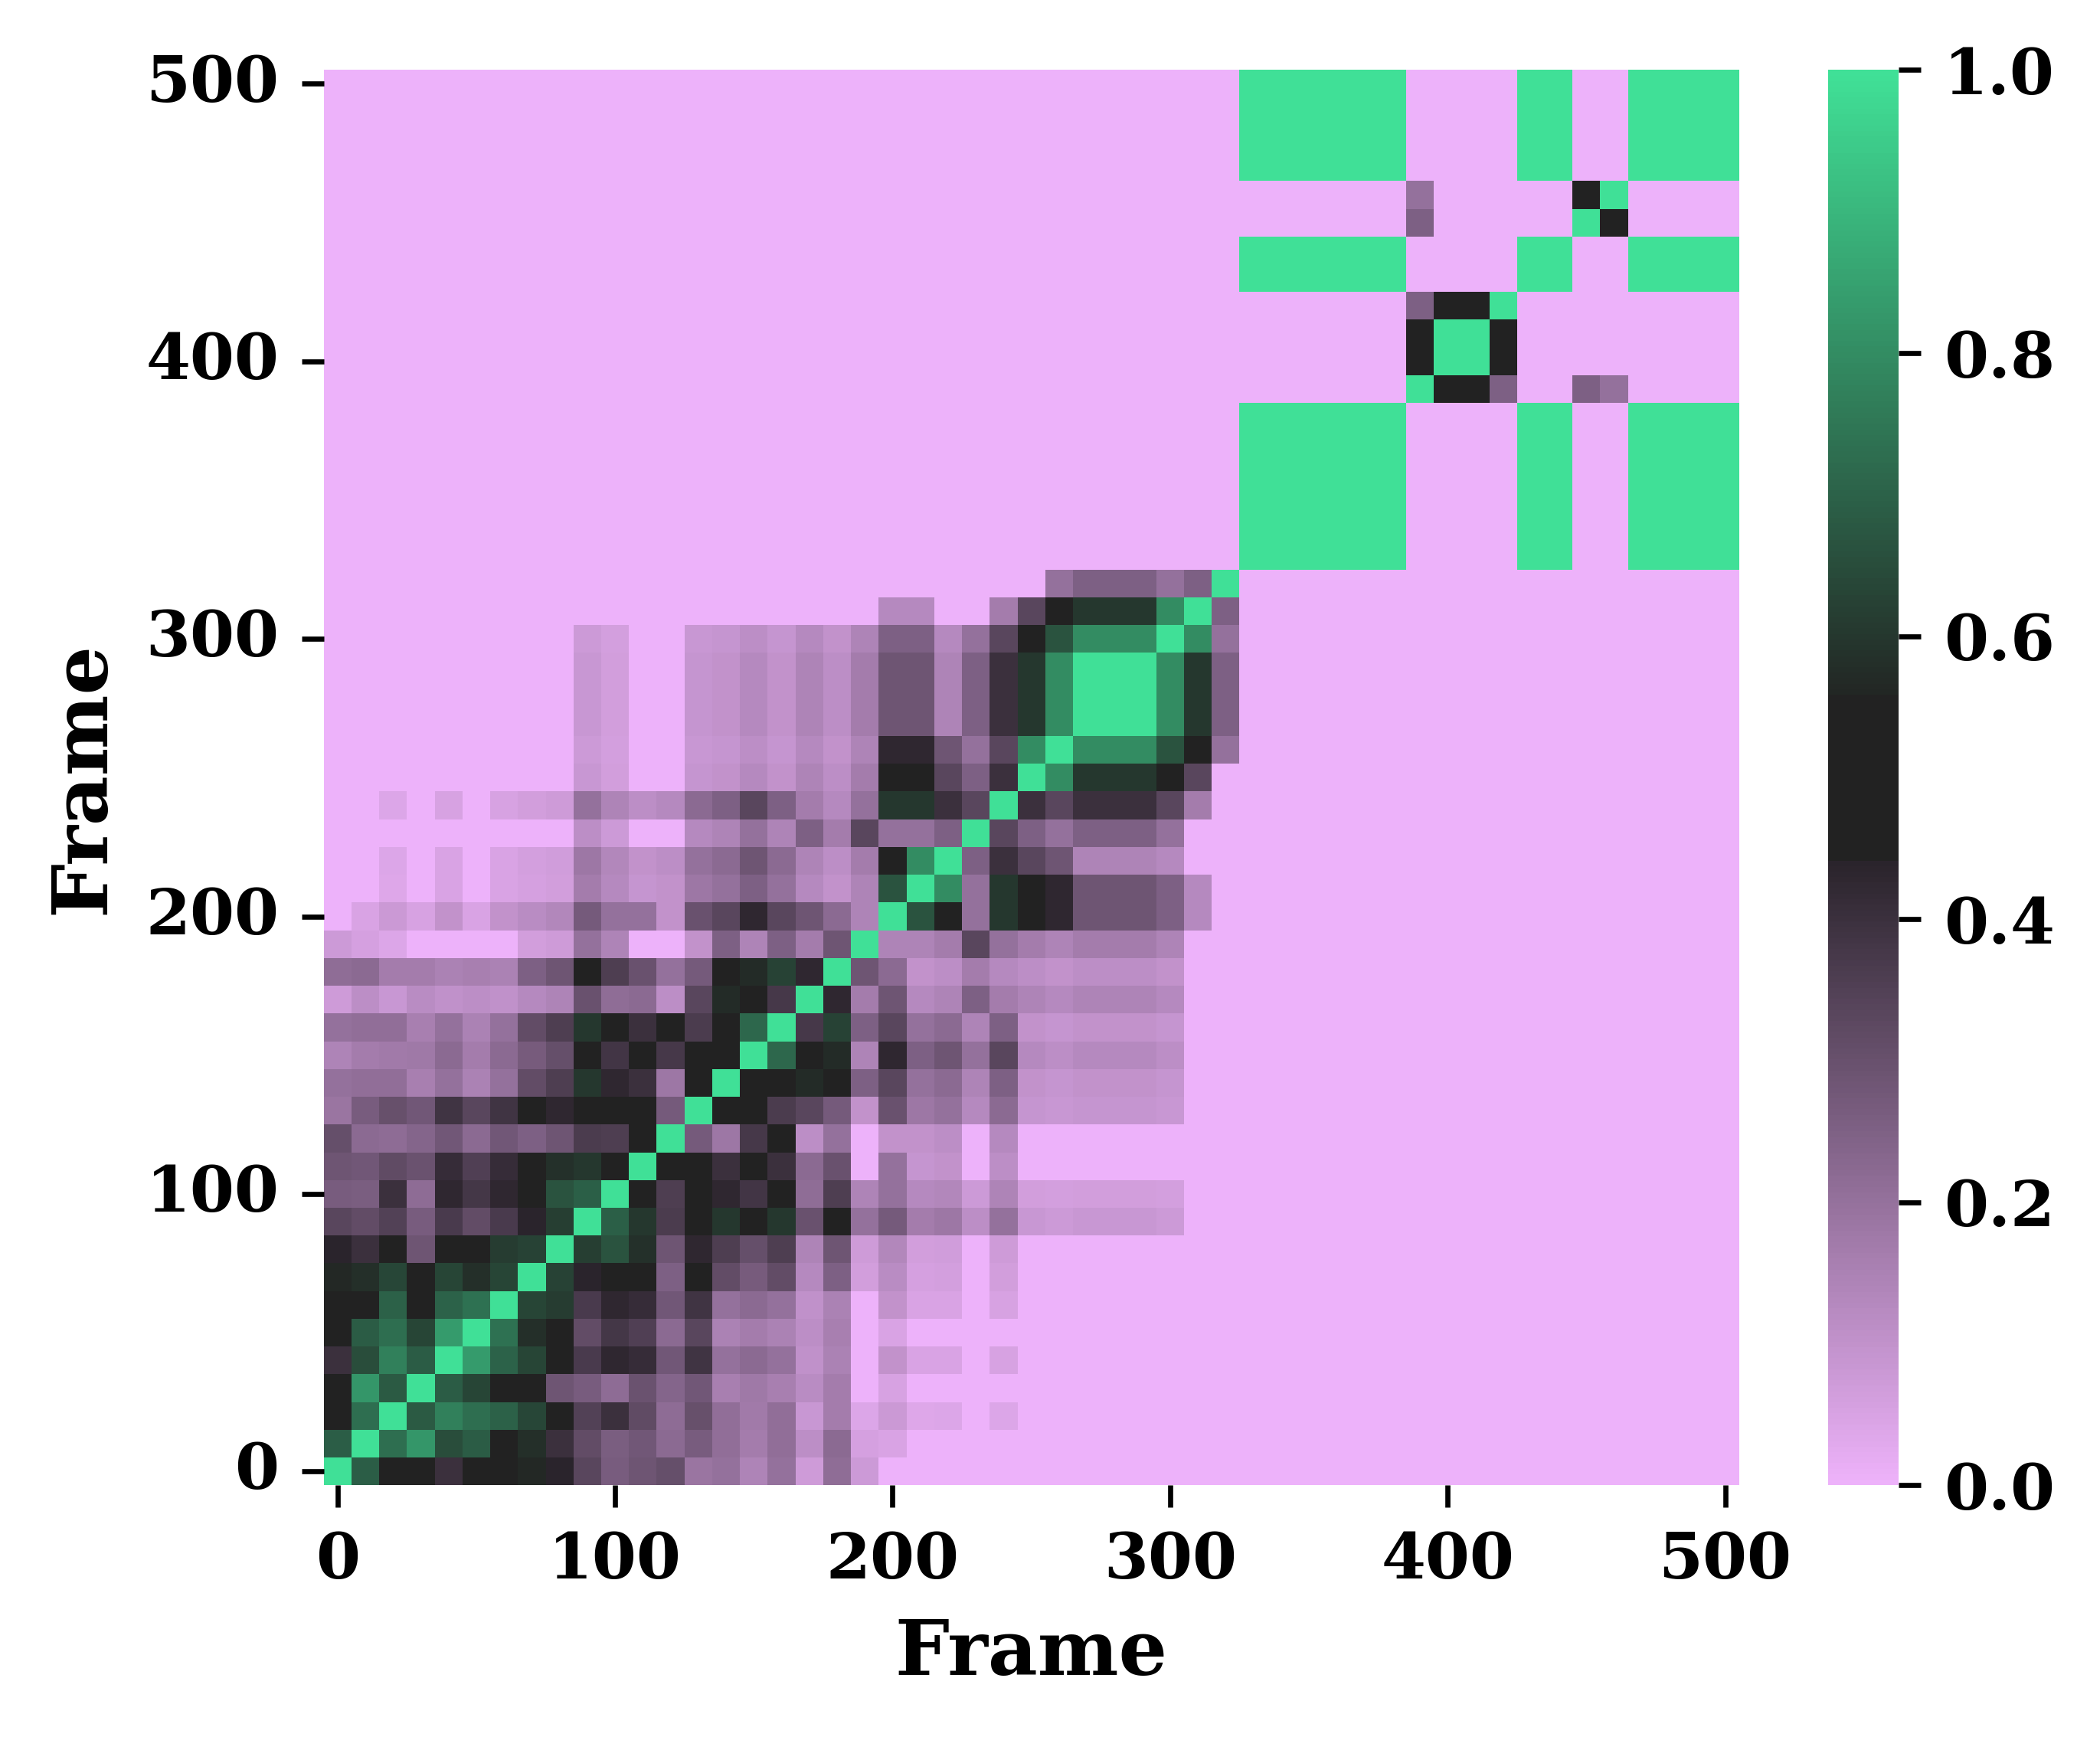

In [25]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Tanimoto similarity matrix
bitvectors = fp.to_bitvectors()
similarity_matrix = []
for bv in bitvectors:
    similarity_matrix.append(DataStructs.BulkTanimotoSimilarity(bv, bitvectors))
similarity_matrix = pd.DataFrame(similarity_matrix, index=df.index, columns=df.index)

# display heatmap
fig, ax = plt.subplots(figsize=(5, 4), dpi=600)
colormap = sns.diverging_palette(
    300, 145, s=90, l=80, sep=30, center="dark", as_cmap=True
)
sns.heatmap(
    similarity_matrix,
    ax=ax,
    square=True,
    cmap=colormap,
    vmin=0,
    vmax=1,
    center=0.5,
    xticklabels=10,
    yticklabels=10,
)

# 设置X和Y轴标签字体加粗
ax.set_xlabel('Frame', fontsize=12, fontweight='bold')  # 修改为需要的X轴标签
ax.set_ylabel('Frame', fontsize=12, fontweight='bold')  # 修改为需要的Y轴标签

ax.invert_yaxis()  # 反转Y轴
plt.yticks(rotation="horizontal")
fig.patch.set_facecolor("white")

# 保存为SVG文件
plt.savefig('./frame500/CtMGAM-Gen-sMD.svg', format='svg')

plt.show()

## Visualisation

There are a few different options builtin when it comes to visualisation.

You can start by plotting the interactions over time:

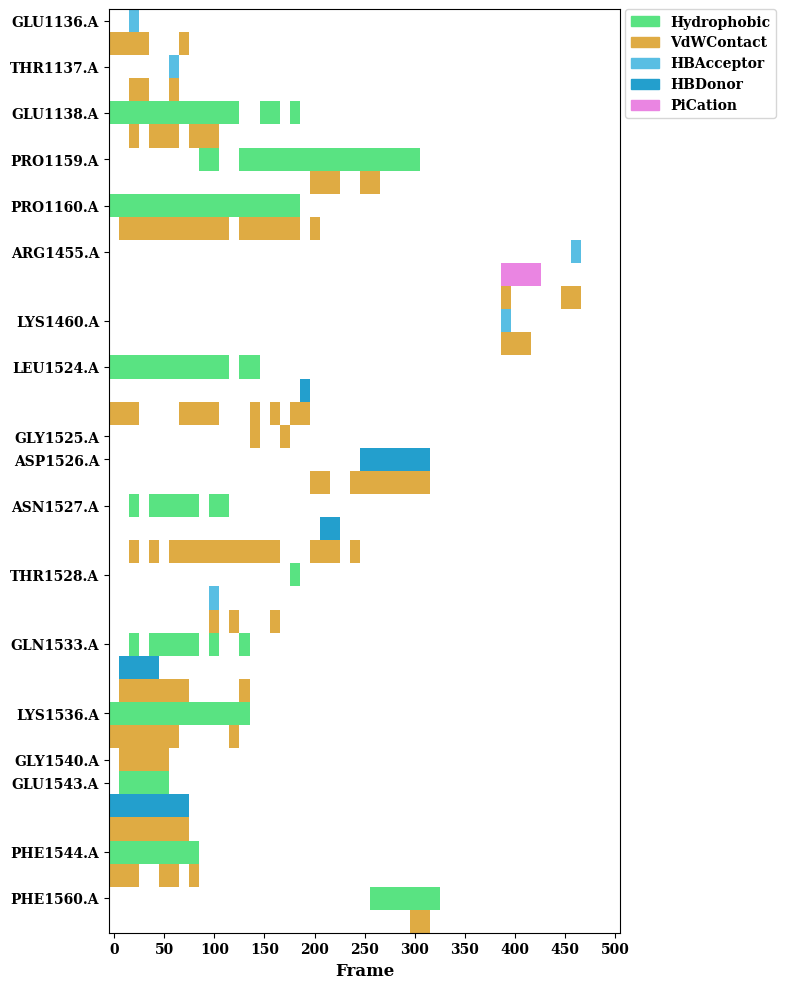

In [24]:
# %matplotlib ipympl

# 绘制条形码图
fp.plot_barcode()

# 获取当前轴对象并设置X轴标题加粗
plt.xlabel('Frame', fontsize=12, fontweight='bold')  # 修改为需要的X轴标签

# # 保存图像为SVG格式, 放在PPT里面模糊
# plt.savefig('./frame100/IFP-CtMGAM-Myr-100ns.svg', format='svg')

# 保存图像为600dpi的TIFF格式
plt.savefig('./frame500/IFP-CtMGAM-Gen-sMD.tif', format='tif', dpi=600)

# 显示图像
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


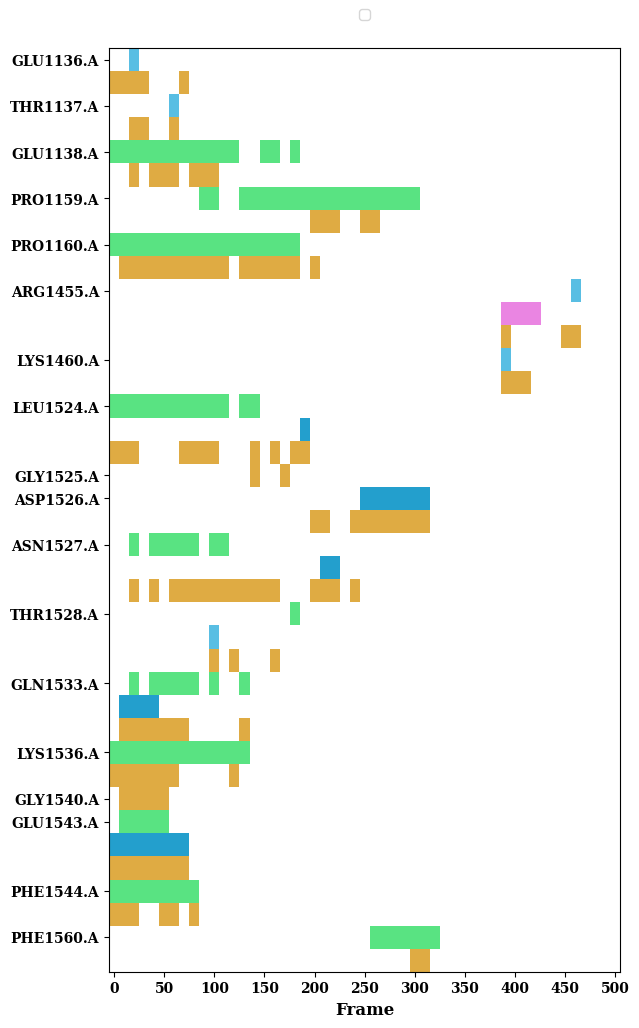

In [28]:
# %matplotlib ipympl

# 绘制条形码图
fp.plot_barcode()

# 获取当前轴对象并设置X轴标题加粗
plt.xlabel('Frame', fontsize=12, fontweight='bold')  # 修改为需要的X轴标签

# 设置图例在图片的正上方
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)  # 调整图例位置

# # 保存图像为SVG格式
# plt.savefig('./frame100/IFP2-CtMGAM-Myr-100ns.svg', format='svg')

# 保存图像为600dpi的TIFF格式
plt.savefig('./frame500/IFP2-CtMGAM-Gen-sMD.tif', format='tif', dpi=600)

# 显示图像
plt.show()

:::{tip}
If you uncomment `%matplotlib ipympl` at the top of the above cell, you should be able to see an interactive version of the plot.
:::

You can also display the interactions in a 2D interactive diagram:

In [29]:
view = fp.plot_lignetwork(ligand_mol)
view

This diagram is interactive, you can:
- zoom and pan,
- move residues around,
- click on the legend to display or hide types of residues or interactions,
- hover an interaction line to display the distance.

:::{note}
After arranging the residues to your liking, you can save the plot as a PNG image with:
```python
view.save_png()
```
Note that this only works in notebooks and cannot be used in regular Python scripts.
:::

You can generate 2 types of diagram with this function, controlled by the `kind` argument:
- `frame`: shows a single specific frame (specified with `frame`, corresponds to the frame number in the simulation).
- `aggregate` (default): the interactions from all frames are grouped and displayed. An optional `threshold` parameter controls the minimum frequency required for an interaction to be displayed (default `0.3`, meaning that interactions occuring in less than 30% of frames will be hidden). The width of interactions is linked to the frequency.

Some more examples:

In [30]:
view = fp.plot_lignetwork(ligand_mol, threshold=0.0)
view

Up to now we've only been using the default fingerprint generator, but you can optionally enable the `count` parameter to enumerate all occurences of an interaction (the default fingerprint generator will stop at the first occurence), and then display all of them by specifying `display_all=True`:

In [31]:
# 主要用于计算某段轨迹里面的某一帧轨迹的相互作用指纹
fp_count = plf.Fingerprint(count=True)
fp_count.run(u.trajectory[0:10], ligand_selection, protein_selection)
# 修改 frame 参数为 9 或更小的值，确保在有效范围内
view = fp_count.plot_lignetwork(ligand_mol, kind="frame", frame=0, display_all=True)
view

  0%|          | 0/10 [00:00<?, ?it/s]

In [45]:
# print(fp_count.ifp)

You can also visualize this information in 3D:

In [32]:
frame = 0
# seek specific frame
u.trajectory[frame]
ligand_mol = plf.Molecule.from_mda(ligand_selection)
protein_mol = plf.Molecule.from_mda(protein_selection)
# display
view = fp_count.plot_3d(ligand_mol, protein_mol, frame=frame, display_all=False)
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

As in the lignetwork plot, you can hover atoms and interactions to display more information.

The advantage of using a count fingerprint in that case is that it will automatically select the interaction occurence with the shortest distance for a more intuitive visualization.

Once you're satisfied with the orientation, you can export the view as a PNG image with:

```python
view.save_png()
```
Note that this only works in notebooks and cannot be used in regular Python scripts.

You can also compare two different frames on the same view, and the protein residues that have
different interactions in the other frame or are missing will be highlighted in magenta:

In [33]:
from prolif.plotting.complex3d import Complex3D

frame = 0
u.trajectory[frame]
ligand_mol = plf.Molecule.from_mda(ligand_selection)
protein_mol = plf.Molecule.from_mda(protein_selection)
comp3D = Complex3D.from_fingerprint(fp, ligand_mol, protein_mol, frame=frame)

frame = 60
u.trajectory[frame]
ligand_mol = plf.Molecule.from_mda(ligand_selection)
protein_mol = plf.Molecule.from_mda(protein_selection)
other_comp3D = Complex3D.from_fingerprint(fp, ligand_mol, protein_mol, frame=frame)

view = comp3D.compare(other_comp3D)
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.